<h1 align="center">Wikipedia Application Prediction</h1>

With both map and reduce stages, let's try to predict the whole application time by adding both durations.

In [1]:
# Notebook configuration, modules import, functions

# plots in the notebook
%matplotlib inline

# Make graphs more readable
import matplotlib
matplotlib.rcParams.update({'font.size': 16,
                            'font.family': 'serif',
                            'lines.linewidth': 2})
from common import *

In [2]:
apps, worker_amounts = parse_strong_scaling(reduce_outliers=True)
print(len(apps), 'apps parsed.')

149 apps parsed.


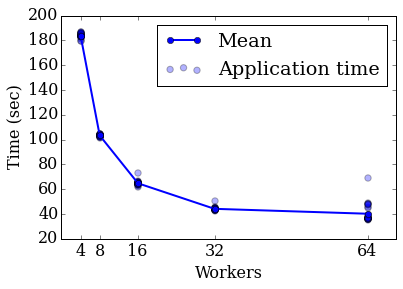

In [3]:
def get_lists_by_wa(apps, fn, fn_results=lambda x: x):
    """ Apply fn to every app and returns a list of the results indexed by worker amount.
    Optionally run fn_results in every worker amount result.
    """
    lists = {}
    [lists.setdefault(a.workers, []).append(fn(a)) for a in apps]
    return [fn_results(lists[wa]) for wa in sorted(lists)]

def get_duration(app):
    return app.duration
    
def list_to_np(numbers):
    return np.array(numbers)

def plt_scatter_per_wa(y_lists, **kwargs):
    for wa, ys in zip(worker_amounts, y_lists):
        xs = [wa] * len(ys)
        plt.scatter(xs, ys, **kwargs)
        if 'label' in kwargs:
            del kwargs['label']

app_durations = get_lists_by_wa(apps, get_duration, list_to_np)
app_means = [d.mean()/1000 for d in app_durations]
plt_scatter_per_wa([d/1000 for d in app_durations], s=40, alpha=0.3, label='Application time')
plt.plot(worker_amounts, app_means, '-o', label='Mean')

plt.xticks(worker_amounts)
plt.xlabel('Workers')
plt.ylabel('Time (sec)')
plt.legend()
plt.show()

## Stages sum

Considering only the sum of the stages is not enough as we can notice in the graph below:

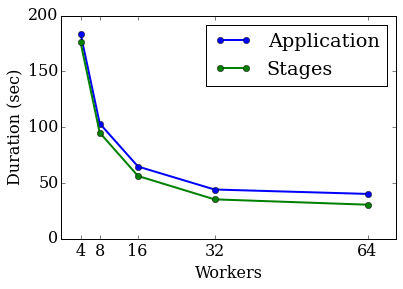

In [4]:
plt.plot(worker_amounts, app_means, '-o', label='Application')

def get_stages_duration(app):
    return sum(stage.tasks_duration() for stage in app.stages)

stg_durations = get_lists_by_wa(apps, get_stages_duration, list_to_np)
stg_means = [d.mean()/1000 for d in stg_durations]
plt.plot(worker_amounts, stg_means, '-o', label='Stages')

plt_setup('Workers', 'Duration (sec)')
plt.xticks(worker_amounts)
plt.legend()
plt.show()

## Initialization delay

In [5]:
def get_delay(app):
    first_task = min(app.stages[0].tasks, key=lambda t: t.start)
    return first_task.start - app.start

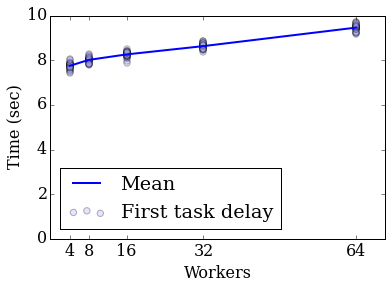

In [6]:
delays = get_lists_by_wa(apps, get_delay, list_to_np)
delay_means = [d.mean()/1000 for d in delays]
plt.plot(worker_amounts, delay_means, label='Mean')

xs = [a.workers for a in apps]
ys = [get_delay(a)/1000 for a in apps]
plt.scatter(xs, ys, s=40, alpha=0.3, c='#AAAAFF', label='First task delay')

plt_setup('Workers', 'Time (sec)')
plt.xticks(worker_amounts)
plt.legend(loc=0)
plt.show()

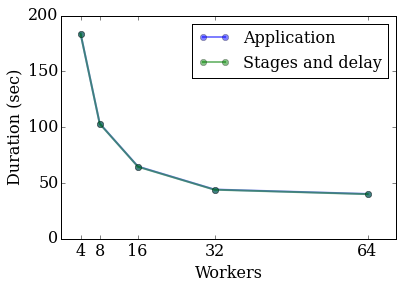

In [7]:
stg_delay_durations = [stages + delay for stages, delay in zip(stg_durations, delays)]
stg_means = [d.mean()/1000 for d in stg_delay_durations]
plt.plot(worker_amounts, app_means, '-o', alpha=0.5, label='Application')
plt.plot(worker_amounts, stg_means, '-o', alpha=0.5, label='Stages and delay')

plt_setup('Workers', 'Duration (sec)')
plt.xticks(worker_amounts)
plt.legend(loc=0, fontsize=16)
plt.show()

# TODO graph with the difference between these two curves that seem like one only.

### Delay prediction

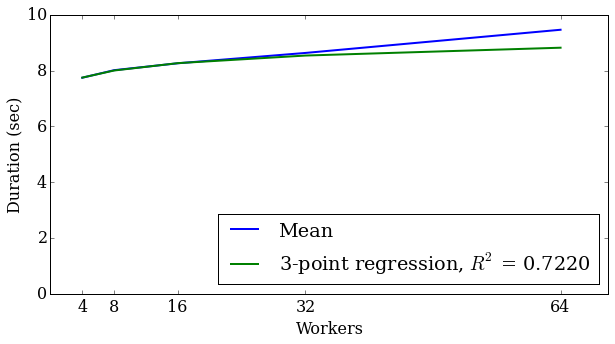

In [8]:
plt.subplots(figsize=(10,5))
plt.plot(worker_amounts, delay_means, label='Mean')

# Curvilinear regression y = ab^x with 4, 8 and 16 workers
_apps = [a for a in apps if a.workers <= worker_amounts[2]]
xs = np.array([a.workers for a in _apps])
ys = np.array([get_delay(a) for a in _apps])
xs_log, ys_log = np.log2(xs), np.log2(ys)
slope, intercept, r_value, p_value, std_err = stats.linregress(xs_log, ys_log)
def curv_reg(x): return 2**intercept * x**slope
r2 = calc_r2_fn(xs, ys, curv_reg)
label = get_r2_label('3-point regression', r2)
plt.plot(worker_amounts, [curv_reg(x)/1000 for x in worker_amounts], label=label)

plt.legend(loc='lower right')
plt.xticks(worker_amounts)
plt_setup('Workers', 'Duration (sec)')
plt.ylim(0, 10)
plt.show()

# TODO improve curvilinear function

### Profiling phase

In [9]:
apps_sss, worker_amounts_sss = parse_sss()
apps_weak, worker_amounts_weak = parse_weak_scaling()

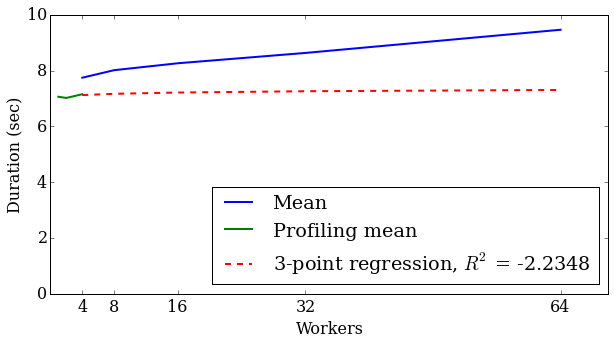

In [10]:
plt.subplots(figsize=(10,5))

plt.plot(worker_amounts, delay_means, label='Mean')

delays_sss = get_lists_by_wa(apps_sss, get_delay, list_to_np)
delay_means_sss = [d.mean()/1000 for d in delays_sss]
plt.plot(worker_amounts_sss, delay_means_sss, label='Profiling mean')

# Curvilinear regression y = ab^x with 4, 8 and 16 workers
_apps = apps_sss
xs = np.array([a.workers for a in _apps])
ys = np.array([get_delay(a) for a in _apps])
xs_log, ys_log = np.log2(xs), np.log2(ys)
slope, intercept, r_value, p_value, std_err = stats.linregress(xs_log, ys_log)
def delay_reg(x): return 2**intercept * x**slope
r2 = calc_r2_fn([a.workers for a in apps], [a.duration for a in apps], delay_reg)
label = get_r2_label('3-point regression', r2)
plt.plot(worker_amounts, [delay_reg(x)/1000 for x in worker_amounts ], '--', label=label)

plt.legend(loc='lower right')
plt.xticks(worker_amounts)
plt_setup('Workers', 'Duration (sec)')
plt.ylim(0, 10)
plt.show()

delay_slope, delay_intercept = slope, intercept

In [11]:
def mean_model(workers, tasks, mean):
    threads = 2 * workers
    return np.ceil(tasks/threads) * mean

# Map model
def two_mean_model(workers, tasks, high_mean, low_mean):
    """
      workers: amount of workers
        tasks: number of tasks
    high_mean: mean duration of the first tasks
     low_mean: mean duration of the remaining tasks
    """
    total_time = high_mean  # all the workers process their first task
    threads = 2 * workers
    total_time += mean_model(workers, tasks - threads, low_mean)
    return total_time

# Reduce model
def linear_mean_model(slope, intercept, workers, tasks):
    mean = slope * workers + intercept
    return mean_model(workers, tasks, mean)

# From Map and Reduce notebooks
n_tasks = 362
high_mean = 9185.3667
low_mean = 3037.6333
reduce_slope = 26.3055
reduce_intercept = 534.2397
reduce_tasks = 200

def map_model(workers): return two_mean_model(workers, n_tasks, high_mean, low_mean)
def reduce_model(workers): return linear_mean_model(reduce_slope, reduce_intercept, workers, reduce_tasks)
def delay_model(workers): return 2**delay_intercept * workers**delay_slope
def app_model(w): return map_model(w) + reduce_model(w) + delay_model(w)

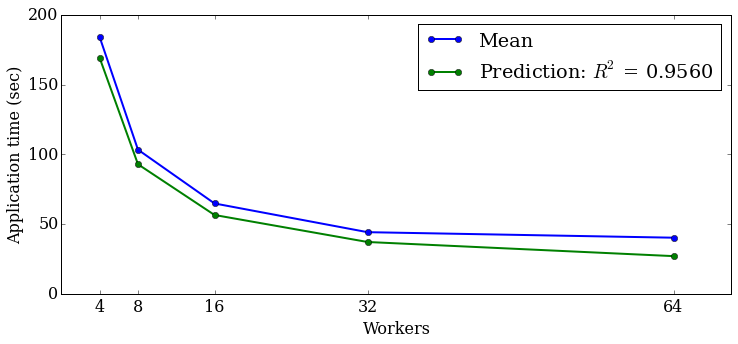

In [12]:
plt.subplots(figsize=(12,5))

_durations = {wa:[] for wa in worker_amounts}
[_durations[a.workers].append(a.duration) for a in apps]
means = [np.mean(_durations[wa])/1000 for wa in worker_amounts]
plt.plot(worker_amounts, means, '-o', label='Mean')

prediction = [app_model(x)/1000 for x in worker_amounts]
r2 = calc_r2(worker_amounts, means, prediction)
label = 'Prediction' + r': $R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, prediction, '-o', label=label)

plt.xticks(worker_amounts)
plt_setup('Workers', 'Application time (sec)')
plt.legend()
plt.show()

The time interval between the application start and the beginning of the first task is depicted below.

# Conclusion

The prediction is good, but can be better if we add other jobs durations (next step).